Primero instalamos todas las librerías


In [14]:
!pip install torch
!pip install matplotlib
!pip install numpy

* `numpy` es el package fundamental para cálculos en Python.
* `matplotlib` es el package para graficar en Python.
* `torch` es el package que usaremos para redes neuronales, de PyTorch.

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import random

In [0]:
import torch
device = torch.device("cuda:0") # Esto es para usar la GPU del computador

Cargamos la base de datos que obtuvimos de Kaggle (plataforma de muchas bases de datos). Esta está subida en un repositorio público de GitHub que creamos en el curso

In [190]:
url = 'https://raw.githubusercontent.com/cacosandon/IND3300-repository/master/dataframe_ind3300.csv'
data = pd.read_csv(url).drop(columns=['index'])

print(data)

                localhour    use  humidity    celsius
0     2018-01-02 01:00:00  0.310      0.78  15.827778
1     2018-01-02 02:00:00  0.273      0.85  14.555556
2     2018-01-02 03:00:00  0.305      0.88  13.694444
3     2018-01-02 04:00:00  0.346      0.90  13.283333
4     2018-01-02 05:00:00  0.391      0.91  12.894444
...                   ...    ...       ...        ...
8682  2018-12-29 19:00:00  0.645      0.36   6.522222
8683  2018-12-29 20:00:00  0.659      0.37   6.033333
8684  2018-12-29 21:00:00  0.617      0.35   6.461111
8685  2018-12-29 22:00:00  0.596      0.35   6.416667
8686  2018-12-29 23:00:00  0.598      0.37   5.994444

[8687 rows x 4 columns]


Investiguemos un poco de la base de datos. Grafiquemos durante 3 días qué pasa con el consumo energético en esta casa. ¿Cómo se relaciona con la temperatura?


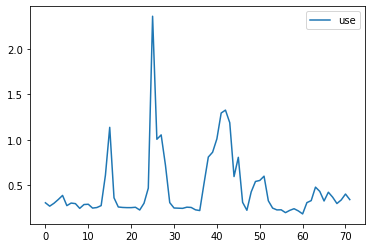

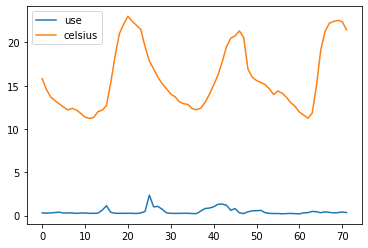

In [191]:
data.iloc[0:72].plot(y=['use'])
data.iloc[0:72].plot(y=['use', 'celsius'])
plt.show()

**Let's predict!**
¿Qué sabemos?

El consumo de energía en un ahora específica se puede relacionar fuertemente con la temperatura, la humedad, la hora del día y obviamente de cómo se ha utilizado la energía horas previas a la estudiada. Dado esto, tendrémos 5 variables de input:


1.   Temperatura 
2.   Humedad
3.   Hora del día 
4.   Uso de energía en t - 1
5.   Uso de energía en t - 2
6.   Uso de energía en t - 3

¿Qué vamos a predecir?
El consumo energético de una hora en específico, sabiendo los datos anteriormente nombrados.


Antes que todo: armar el input!

In [0]:
length = len(data) # Obtenemos cuántas filas de información tenemos
y_size = 1 # Queremos simplemente saber la hora siguiente, a partir de las 3 horas anteriores

X = [] # Este será nuestro input. Una matriz con cada instancia y las variables correspondientes
Y = [] # Este será nuestro output. Un vector (dado que nuestro output es de una dimensión)

# Nos sirve para sacar las variables de día y hora
get_day = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

Debemos crear nuestra propia dataset para comprobar nuestros resultados y entrenar el modelo. Para esto, partimos desde la cuarta fila (i = 3), para así obtener las tres horas anteriores y añadir un dato a nuestra database.

Un dato es variables + output esperado. Las variables se añaden a la matriz X y el output esperado a la matriz Y.

Nos vamos corriendo en el dataframe inicial para crear una cantidad total a 8687 - 4 datos para nuestra red neuronal. Esto porque al final del dataframe no podemos predecir con los últimos 3 datos (sólo con los últimos 4).

 **OJO: Se demora un poco!**

In [0]:
i = 3
while i < length - 1:
    row = data.loc[i] # Obtenemos la fila
    row_date = get_day(row['localhour']) # Parseamos el string para obtener el formato de fecha
    
    tmprt = row['celsius'] # Primera variable
    hum = row['humidity'] # Segunda variable
    hod = row_date.hour # Tercera variable

    use_1 = data.loc[i-1]['use'] # Cuarta variable
    use_2 = data.loc[i-2]['use'] # Quinta variable
    use_3 = data.loc[i-3]['use'] # Sexta variable
    
    X.append([tmprt, hum, hod, use_1, use_2, use_3]) # Añadimos a el input la fila de variables
    Y.append([data.loc[i + 1]['use']]) # Añadimos el output: predicción de uso energético en hora siguiente
    i += 1

Comprobemos si todo está bien!

In [194]:
print(len(X))
print(len(Y))

8683
8683


Ahora debemos separar en training y test data. Lo que hacemos es obtener un sample de índices que serán el training set, y los restantes serán para el testing set.

In [196]:
indices = random.sample(range(len(X)), int(0.8*len(X))) # Obtenemos 80% de índices aleatorios, que serán nuestras filas de entrenamiento

train_x, train_y, test_x, test_y = [], [], [], []
for i in range(len(X)):
  if i in indices:
    train_x.append(X[i])
    train_y.append(Y[i])
  else:
    test_x.append(X[i])
    test_y.append(Y[i])

print(f"La cantidad de datos para el training son {len(train_x)}")


La cantida de datos para el training son 6946


In [198]:
# Obtenemos X y Y sampleados y los pasamos a torch, el vector que ocupa PyTorch para ocupar la GPU
x, y = torch.from_numpy(np.array(train_x)).float(), torch.from_numpy(np.array(train_y)).float()

print(x, "\n", y)

tensor([[12.1944,  0.8500,  7.0000,  0.2790,  0.3910,  0.3460],
        [12.3889,  0.9000,  8.0000,  0.3070,  0.2790,  0.3910],
        [12.1889,  0.9000,  9.0000,  0.3010,  0.3070,  0.2790],
        ...,
        [ 6.0333,  0.3700, 20.0000,  0.6450,  0.6980,  0.8990],
        [ 6.4611,  0.3500, 21.0000,  0.6590,  0.6450,  0.6980],
        [ 6.4167,  0.3500, 22.0000,  0.6170,  0.6590,  0.6450]]) 
 tensor([[0.3010],
        [0.2490],
        [0.2910],
        ...,
        [0.6170],
        [0.5960],
        [0.5980]])


Creamos la clase que será nuestra red neuronal. Tenemos las capas de entrada y salida:

*   self.input_linear
*   self.output_linear

Y tenemos las capas ocultas o *hidden layers*, donde la primera será una con la función de activación "Linear" y la segunda tendrá una función de activación "ReLU".



In [0]:
# Usamos el paquete "nn" para definir el modelo y la función de estimación del error.
class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.hidden_layer = torch.nn.Linear(H, H)
        self.hidden_layer2 = torch.nn.ReLU()
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
      
        h = self.input_linear(x)
        h_hidden = self.hidden_layer(h)
        h_hidden2 = self.hidden_layer2(h_hidden)
        y_pred = self.output_linear(h_hidden2)
        return y_pred

# Tenemos 6 variables de entrada, usaremos 32 neuronas por capa, 1 dato de salida
model = DynamicNet(6, 32, 1)

# Función de error MSE
criterion = torch.nn.MSELoss(reduction='mean')

# Optimizador de redes neuronales que nos entre PyTorch
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [200]:
# Especificamos las 5000 iteraciones
for t in range(5000):
    # Calculamos la predicción con el modelo actual. "Forward"
    y_pred = model(x)

    # Calculamos el error e imprimimos cada 500 iteraciones.
    loss = criterion(y_pred, y)
    if t % 500 == 99:
        print(t, loss.item())

    # Ejecutamos la calibración de los pesos. "Backward"
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 0.20113196969032288
599 0.16925166547298431
1099 0.14995290338993073
1599 0.13737352192401886
2099 0.1280684471130371
2599 0.12168078869581223
3099 0.1176317036151886
3599 0.11515340209007263
4099 0.11359445005655289
4599 0.11228422820568085


Dado que nuestro modelo está entrenado, entonces procederemos a probarlo con el test dataset. Para esto, graficaremos el test y su respectiva predicción con el modelo entrenado.

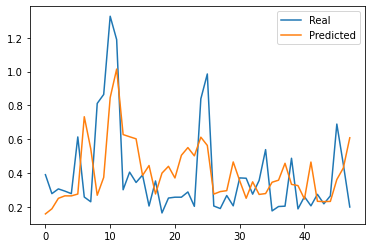

In [205]:
real = [] # Almacenamos valores reales
pred = [] # Almacenamos valores predecidos
for i in range(48):
  x, y = test_x[i], test_y[i]
  real += list(y) # Agregamos el que ya tenemos
  outputs = model(torch.from_numpy(np.array(x)).float()) # Predecimos
  pred += list(outputs.to("cpu")) # Agregamos el que predecimos

# Plot the results
fig, ax = plt.subplots()
ax.plot(real, label="Real")
ax.plot(pred, label="Predicted")
ax.legend()
plt.show()